<a href="https://colab.research.google.com/github/nataliasc/dyadicdecisionmaking/blob/2ifc-random-dots/dataanalysis/compact_fitHDDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Estimate DDM parameters using HDDM **

adapted from Anne Urai's fitHDDM.py script https://github.com/anne-urai/2019_Urai_choice-history-ddm/blob/master/fitHDDM.py

# Set up section

In [ ]:
!apt-get install python3.5

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.5-minimal libpython3.5-stdlib python3.5-minimal
Suggested packages:
  python3.5-venv python3.5-doc binfmt-support
The following NEW packages will be installed:
  libpython3.5-minimal libpython3.5-stdlib python3.5 python3.5-minimal
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,135 kB of archives.
After this operation, 22.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.5-minimal amd64 3.5.10-1+bionic2 [542 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 python3.5-minimal amd64 3.5.10-1+bionic2 [1,273 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 libpython3.5-stdlib amd64 3.5.10-1+bionic2 [2,107 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd

In [ ]:
!pip install pymc

     |████████████████████████████████| 385 kB 7.5 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1353142 sha256=3042175135779452dd3086b2715ebb9688851f196f9f6b8748bd9aa6b4ef6846
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc


In [ ]:
!pip install pandas patsy

In [ ]:
!pip install kabuki

     |████████████████████████████████| 44 kB 2.1 MB/s 
  Created wheel for kabuki: filename=kabuki-0.6.3-py3-none-any.whl size=36545 sha256=38a708346c6f106d0bbd3a4951fbe367ead0f9adc0f7d008d0b4ad8654c34a48
  Stored in directory: /root/.cache/pip/wheels/29/cb/6a/02f80c7cde0e973c5ec0f4202aee3ab1b10d84682052d99af5
Successfully built kabuki


In [ ]:
!pip install hddm

     |████████████████████████████████| 601 kB 9.2 MB/s 
  Created wheel for hddm: filename=HDDM-0.8.0-cp37-cp37m-linux_x86_64.whl size=556555 sha256=3235354b27d9f0374cf1f5477f1ed8eb836bffc78e88353e30311e1c8ecdecf5
  Stored in directory: /root/.cache/pip/wheels/13/13/8b/4fb929469ddb2844cc33d7e3331aaae7668152b496f4fab402
Successfully built hddm


In [ ]:
import glob
import hddm
import kabuki
import numpy as np
import os
import pandas as pd
import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [ ]:
print(hddm.__version__)

0.8.0


# Helper functions

In [97]:
def recode_4stimcoding(mydata):
    #code stimulus and response direction left as 0, leave direction right as 1.
    
    mydata.loc[mydata['direction']==-1,'direction'] = 0
    mydata.loc[mydata['response']==-1,'response'] = 0
    for col in mydata.columns.tolist():
        if ('stim' in col) or ('resp' in col):
            mydata.loc[mydata[col]==-1,col] = 0
    
    return mydata

def z_link_func(x):
    return 1 / (1 + np.exp(-(x.values.ravel())))

def aic(self):
    k = len(self.get_stochastics())
    logp = sum([x.logp for x in self.get_observeds()['node']])
    return 2 * k - 2 * logp


def bic(self):
    k = len(self.get_stochastics())
    n = len(self.data)
    logp = sum([x.logp for x in self.get_observeds()['node']])
    return -2 * logp + k * np.log(n)

def concat_models(mypath, model_name, nchains=30):
    traces = range(1,nchains+1)

    # CHECK IF COMBINED MODEL EXISTS
    if os.path.isfile(os.path.join(mypath, model_name, 'modelfit-combined.model')):
        print("Combined Model exists: {}".format(os.path.join(mypath, model_name, 'modelfit-combined.model')))
    else:
        # ============================================ #
        # APPEND MODELS
        # ============================================ #
        allmodels = []
        print("Combining all traces for %s" % model_name)
        for trace_id in traces:  # how many chains were run?
            model_filename = os.path.join(mypath, model_name, 'modelfit-md%d.model' % trace_id)
            if os.path.isfile(model_filename) == True:  # if not, this model has to be rerun
                print(model_filename)
                thism = hddm.load(model_filename)
                allmodels.append(thism)  # now append into a list
            else:
                print("Not found: trace_id {:2d}".format(trace_id))
                
        if len(allmodels) != nchains:
            return None
        # ============================================ #
        # CHECK CONVERGENCE if all traces were found
        # ============================================ #    
        print("Performing gelman rubin convergence test\n")
        try:
            gr = hddm.analyze.gelman_rubin(allmodels)
            # save
            text_file = open(os.path.join(mypath, model_name, 'gelman_rubin.txt'), 'w')
            for p in gr.items():
                text_file.write("%s,%s\n" % p)
                # print a warning when non-convergence is detected
                # Values should be close to 1 and not larger than 1.02 which would indicate convergence problems.
                # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3731670/
                if abs(p[1] - 1) > 0.02:
                    print("non-convergence found, %s:%s" % p)
            text_file.close()
            print("written gelman rubin stats to file")
        except Exception as e:
            print("Error: {}".format(e))
        m = kabuki.utils.concat_models(allmodels) #creates one model from all chains

        # ============================================ #
        # SAVE THE FULL MODEL
        # ============================================ #

        m.save(os.path.join(mypath, model_name, 'modelfit-combined.model'))  # save combined modelto disk
        print("Concatenated model saved!")
        
        # ============================================ #
        # SAVE POINT ESTIMATES
        # ============================================ #

        print("saving stats...")
        results = m.gen_stats()  # point estimate for each parameter and subject
        results.to_csv(os.path.join(mypath, model_name, 'results-combined.csv'))

        # save the DIC for this model
        text_file = open(os.path.join(mypath, model_name, 'DIC-combined.txt'), 'w')
        text_file.write("Combined model: {}\n".format(m.dic))
        text_file.close()
        print('done')
        
        # ============================================ #
        # SAVE TRACES
        # ============================================ #

        print("saving traces...")
        # get the names for all nodes that are available here
        group_traces = m.get_group_traces()
        group_traces.to_csv(os.path.join(mypath, model_name, 'group_traces.csv'))

        all_traces = m.get_traces()
        all_traces.to_csv(os.path.join(mypath, model_name, 'all_traces.csv'))
        print('done')
        
        # ============================================ #
        # CONCATENATE MODEL COMPARISON
        # ============================================ #
        # average model comparison values across chains
        print('concatenating model comparison...')
        fls = glob.glob(os.path.join(mypath, model_name, 'model_comparison_md*.csv'))
        tmpdf = pd.concat([pd.read_csv(f) for f in fls ])
        # average over chains
        df2 = tmpdf.mean()
        df2 = tmpdf.describe().loc[['mean']]
        df2.to_csv(os.path.join(mypath, model_name, 'model_comparison.csv')) # save comparison to disk
        print('done')


        # DELETE FILES to save space
        print("Now deleting files for seperate chains...")
        for fl in glob.glob(os.path.join(mypath, model_name, 'modelfit-md*.model')):
            print(fl)
            os.remove(fl)
        for fl in glob.glob(os.path.join(mypath, model_name, 'modelfit-md*.db')):
            if not '-md1.db' in fl: #needed here to load the pickled db in PPC
                print(fl)
                os.remove(fl)
        for fl in glob.glob(os.path.join(mypath, model_name, 'model_comparison_md*.csv')):
            print(fl)
            os.remove(fl)
        for fl in glob.glob(os.path.join(mypath, model_name, 'DIC-md*.txt')):
            print(fl)
            os.remove(fl)
        print('DONE!!!')


In [ ]:
def make_model(mydata, model_name, trace_id, nlag=0):
    
    #checks before model is created
    if "nohist" not in model_name and nlag == 0:
        print("For all models with history effects, 'nlag' must be non-zero")
        exit(0)
    elif "nohist" in model_name and nlag != 0:
        print("'nlag' specified but model is without history effect. 'nlag' value is ignored\n")
        nlag = 0
         
    if 'regress' in model_name:
        if nlag != 0:
            lags = range(1,nlag+1)
            resp_cols = ['l' + str(i) + '_resp' for i in lags]
            stim_cols = ['l' + str(i) + '_stim' for i in lags]
            resps = " + ".join(resp_cols)
            respstim = " + ".join(resp_cols + stim_cols)
            for col in stim_cols:
                mydata = mydata[mydata[col].notna()]
    else:
        mydata = recode_4stimcoding(mydata)
        if nlag != 0:
            col_resp = 'l' + str(nlag) + '_resp'
            col_stim = 'l' + str(nlag) + '_stim'
            col_subject = 'l' + str(nlag) + '_subject'
            col_repeat = 'l' + str(nlag) + '_repeat'
             
    if model_name == 'stimcoding_nohist': # NO HISTORY FOR MODEL COMPARISON
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'])
    elif model_name == 'stimcoding_dc_resp':
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'],
                depends_on={'dc':[col_resp]})
    elif model_name == 'stimcoding_z_resp':
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'],
                depends_on={'z':[col_resp]})
    elif model_name == 'stimcoding_dc_z_resp':
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'],
                depends_on={'dc':[col_resp], 'z':[col_resp]})
    elif model_name == 'stimcoding_dc_z_st_resp': # also estimate across-trial variability in nondecision time
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz', 'st'), group_only_nodes=['sv', 'sz', 'st'],
                depends_on={'dc':[col_resp], 'z':[col_resp]})
    # ============================================ #
    # Dyadic models..depends on whether the lagged trial was own for partner's
    # ============================================ #
    elif model_name == 'stimcoding_dc_z_resp_dyadic':
        m = hddm.HDDMStimCoding(mydata, stim_col='direction', split_param='v',
                drift_criterion=True, bias=True, p_outlier=0.05,
                include=('sv', 'sz'), group_only_nodes=['sv', 'sz'],
                depends_on={'dc':[col_resp, col_subject], 'z':[col_resp, col_subject]})
    
    return m

In [ ]:
def get_full_model_name(m,lag):
    return m if 'nohist' in m else m + '_l' + str(lag)

In [ ]:
def run_model(m, mypath, model_name, trace_id, n_samples):
    print("Running {:<s}, trace_id {:2d}".format(model_name,trace_id))
    print("finding starting values")
    try:
        m.find_starting_values() # this should help the sampling
    except Exception as e:
        print(e) #even if starting values couldnt be found, sampling can continue

    print("begin sampling")
    #m.sample(n_samples, burn=n_samples/2, thin=3)
    
    m.sample(n_samples, burn=n_samples/2, thin=3, db='pickle',
        dbname=os.path.join(mypath, model_name, 'modelfit-md%d.db'%trace_id))
    m.save(os.path.join(mypath, model_name, 'modelfit-md%d.model'%trace_id)) # save the model to disk
    
    # ============================================ #
    # save the output values
    # ============================================ #

    # save the DIC for this model
    text_file = open(os.path.join(mypath, model_name, 'DIC-md%d.txt'%trace_id), 'w')
    text_file.write("Model {}: {}\n".format(trace_id, m.dic))
    text_file.close()

    # save the other model comparison indices
    df = dict()
    df['trace_id'] = trace_id
    df['dic_original'] = [m.dic]
    df['aic'] = [aic(m)]
    df['bic'] = [bic(m)]
    df2 = pd.DataFrame(df)
    df2.to_csv(os.path.join(mypath, model_name, 'model_comparison_md%d.csv'%trace_id),index=False)


# Prep before running HDDM

In [108]:
models_collection = {
    1: 'stimcoding_nohist',  # no history baseline model
    2: 'stimcoding_dc_resp',  #previous response dependent, nlags needed
    3: 'stimcoding_z_resp',  #previous response dependent, nlags needed
    4: 'stimcoding_dc_z_resp', #previous response dependent, nlags needed
    5: 'stimcoding_dc_z_st_resp',  #previous response dependent, nlags needed
    6: 'stimcoding_dc_z_resp_dyadic' #previous response dependent, nlags needed, dyadic assessment
}


In [109]:
"""
Prepare for running: Part I
Select model and the nth prev trial intended to be analyzed
"""
model = models_collection[1]
lag = 1
chains = 2
trace_ids = range(1,chains+1)
n_samples = 5000

mypath = "drive/MyDrive/DDM_SP_2021-22/data/output"
full_model_name = get_full_model_name(model,lag)
thispath = os.path.join(mypath,full_model_name)
if not os.path.exists(thispath):
    os.makedirs(thispath)


In [110]:
"""
Prepare for running:Part II
Setup the folders and fetch data
"""
datasrc = "drive/MyDrive/DDM_SP_2021-22/data/coded"
datafile = "all_trials_data.csv"

#if the concatenated data from each experimnetal run exists, use that, else create the concatenated data first
data_loc = os.path.join(datasrc,datafile)
if os.path.exists(data_loc):
    mydata = hddm.load_csv(data_loc)
    print("Concatenated datafile with full experiment data found and loaded")
else:
    files = glob.glob(os.path.join(datasrc,'pair*.csv'))
    mydata = pd.concat([pd.read_csv(f) for f in files ])
    mydata.to_csv(data_loc,index=False,header=True)
    print("Concatenated datafile with full experiment data created")


Concatenated datafile with full experiment data found and loaded


**Data preparation for HDDMStimCoding**

In [111]:
#remove columns not needed
col_prefix = 'l' + str(lag) + '_'
cols_to_drop = [x for x in mydata.columns if (x[0] == 'l') and (not col_prefix in x)]
cols_to_drop.extend(['run_id','correct','block','trial'])
mydata.drop(columns=cols_to_drop,axis=1,inplace=True)

#recode the subject in lagged trial..own:1, partner:0
mask = mydata[col_prefix + 'subject'] == mydata['subj_idx']
mydata[col_prefix + 'subject'] = (mydata[col_prefix + 'subject']== mydata['subj_idx']) * 1

#Coding for response column. Use stimulus-coding: 1: right, 0:left
mydata.loc[mydata['response'] == -1,'response'] = 0
mydata.loc[mydata[col_prefix + 'resp'] == -1,col_prefix + 'resp'] = 0

"""
HDDMStimCoding: Add a column to your data that codes which stimulus was correct.
For identifier 1, drift-rate v will be used while for identifier 0, -v will be used.
"""
#Coding for direction column. 1:right,0:left
mydata.loc[mydata['direction'] == -1,'direction'] = 0
mydata.loc[mydata[col_prefix + 'stim'] == -1,col_prefix + 'stim'] = 0

In [112]:
mydata

,direction,response,rt,subj_idx,l1_stim,l1_resp,l1_subject,l1_repeat
0,1,1,1.276171,280933_1,NaN,NaN,0,0.0
1,1,0,1.399132,280933_2,1.0,1.0,0,0.0
2,1,0,1.317045,280933_2,1.0,0.0,1,1.0
3,0,1,1.390721,280933_2,1.0,0.0,1,0.0
4,0,0,1.169879,280933_1,0.0,1.0,0,0.0
...,...,...,...,...,...,...,...,...
9544,0,0,0.711276,476030_1,1.0,0.0,0,1.0
9545,1,1,0.943320,476030_2,0.0,0.0,0,0.0
9546,0,1,1.134057,476030_1,1.0,1.0,0,1.0
9547,0,0,0.847869,476030_2,0.0,1.0,0,0.0


#DDM param estimations are done for 3 conditions: 

1. No history condition

2. depends on the lagged trial response 

3. depends on the lagged trial response and own (code 1) or partner (code 0)trial


In [113]:
# ============================================ #
# Main HDDM parameter estimation
# ============================================ #
starttime = time.time()
for trace_id in trace_ids:
    model_filename = os.path.join(mypath, full_model_name, 'modelfit-md%d.model' % trace_id)
    m = make_model(mydata, model, trace_id, lag)
    run_model(m, mypath, full_model_name, trace_id, n_samples)
    elapsed = time.time() - starttime
    print("\nElapsed time for %s, trace_id %d, %d samples: %f seconds\n" % (model, trace_id, n_samples, elapsed))



'nlag' specified but model is without history effect. 'nlag' value is ignored

Running stimcoding_nohist, trace_id  1
finding starting values


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


begin sampling
 [-----------------100%-----------------] 5001 of 5000 complete in 5799.4 sec
Elapsed time for stimcoding_nohist, trace_id 1, 5000 samples: 5811.968464 seconds

'nlag' specified but model is without history effect. 'nlag' value is ignored

Running stimcoding_nohist, trace_id  2
finding starting values


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


begin sampling
 [-----------------100%-----------------] 5001 of 5000 complete in 5795.1 sec
Elapsed time for stimcoding_nohist, trace_id 2, 5000 samples: 11619.558505 seconds



#Check the model and convergence

In [114]:
#load all models
allmodels = []
print("Combining all traces for %s" % full_model_name)
modelfiles = glob.glob(os.path.join(mypath, full_model_name, 'modelfit-md*.model'))
for m in modelfiles:
  try:
    allmodels.append(hddm.load(m))
  except Exception as e:
    print("Couldnt load fitted model {}\n".format(m))
    print(e)
    exit(0)

print("{} traces found and loaded".format(len(modelfiles)))

#GM convergence check
# Values should be close to 1 and not larger than 1.02 
print("\n#####GELMAN RUBIN TEST OUTPUT#####")
try:
  gr = hddm.analyze.gelman_rubin(allmodels)
  for p in gr.items():
    msg = "Non-convergence" if abs(p[1] - 1) > 0.02 else "OK"
    print("{:<24s} {:6.5f} {}".format(p[0],p[1],msg))
except Exception as e:
  print("Error: {}".format(e))

Combining all traces for stimcoding_nohist
2 traces found and loaded

#####GELMAN RUBIN TEST OUTPUT#####
a                        0.99967 OK
a_std                    0.99970 OK
a_subj.268006_1          1.00037 OK
a_subj.268006_2          0.99943 OK
a_subj.280933_1          0.99999 OK
a_subj.280933_2          1.00004 OK
a_subj.476030_1          0.99982 OK
a_subj.476030_2          1.00006 OK
a_subj.659640_1          1.00046 OK
a_subj.659640_2          0.99940 OK
a_subj.725232_1          1.00201 OK
a_subj.725232_2          0.99970 OK
a_subj.754128_1          0.99946 OK
a_subj.754128_2          1.00035 OK
a_subj.812810_1          1.00101 OK
a_subj.812810_2          0.99940 OK
a_subj.897304_1          1.00251 OK
a_subj.897304_2          1.00001 OK
a_subj.900778_1          0.99946 OK
a_subj.900778_2          0.99944 OK
a_subj.958733_1          0.99948 OK
a_subj.958733_2          1.00175 OK
v                        0.99967 OK
v_std                    0.99947 OK
v_subj.268006_1          1.0004

In [118]:
#concat all traces into one model
m = kabuki.utils.concat_models(allmodels)

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std
Plotting sv
Plotting sz
Plotting z
Plotting z_std
Plotting dc
Plotting dc_std


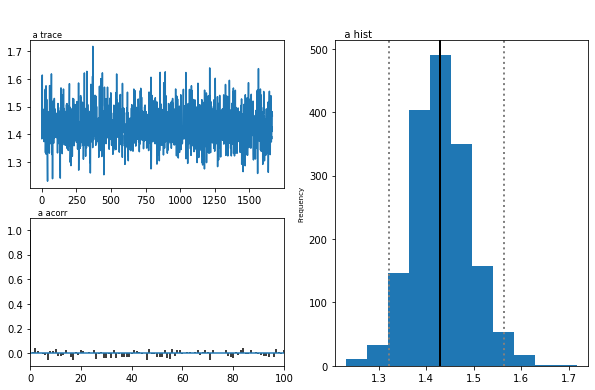

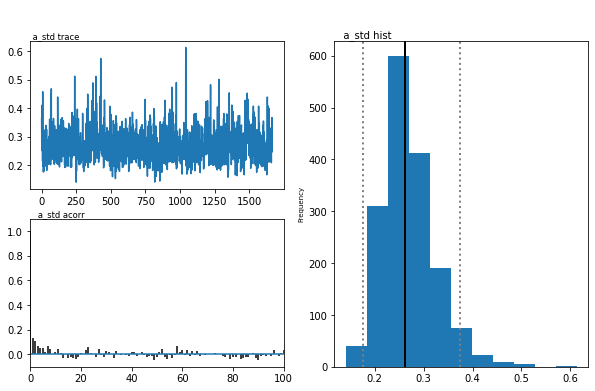

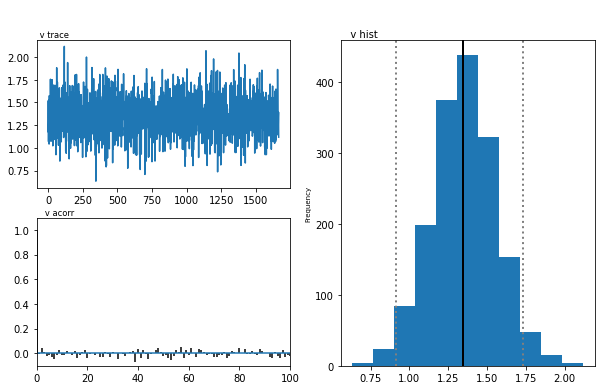

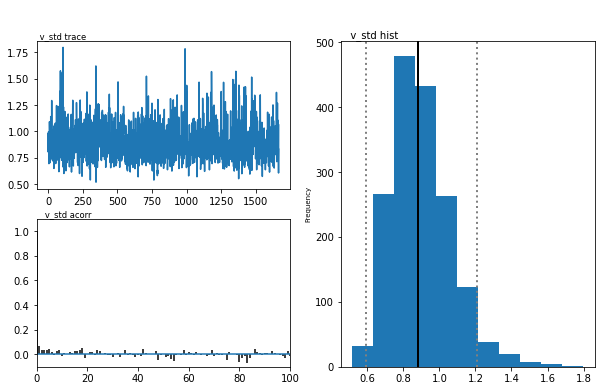

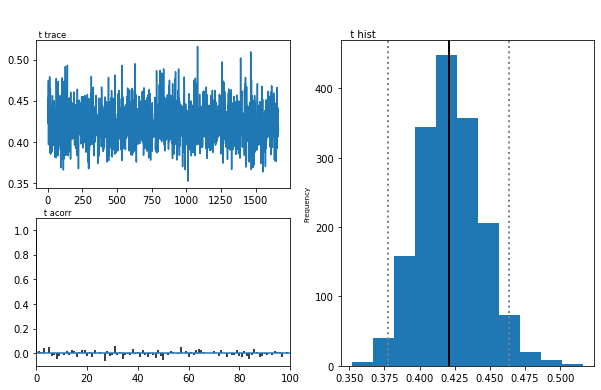

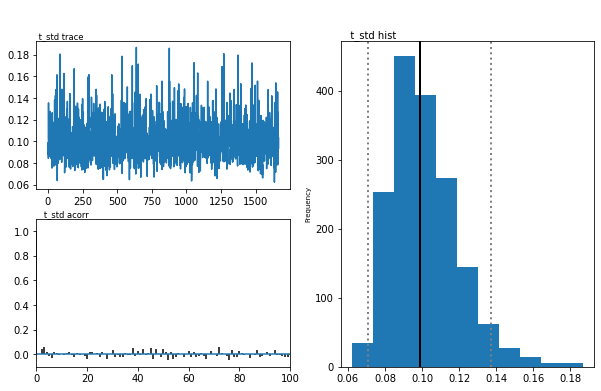

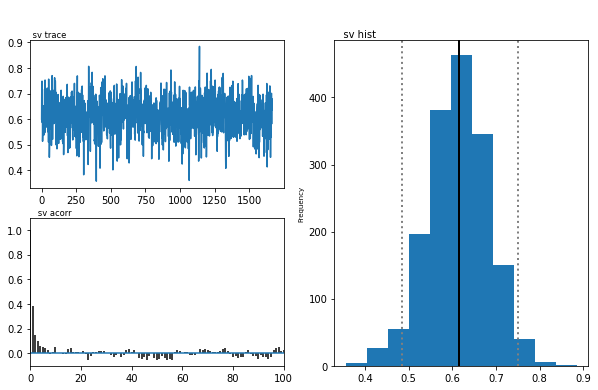

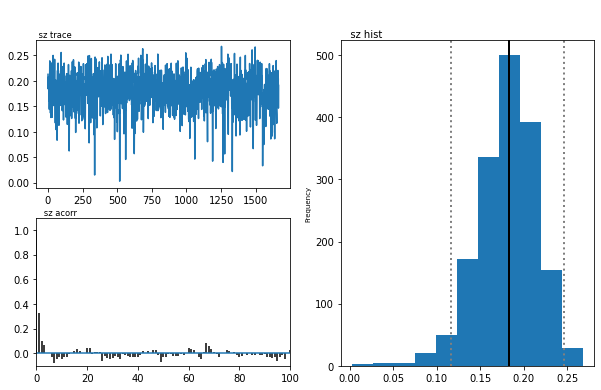

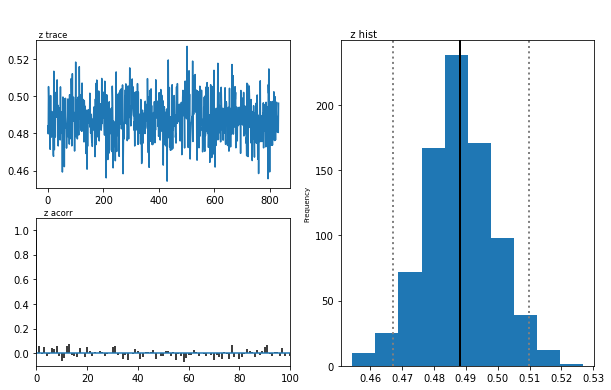

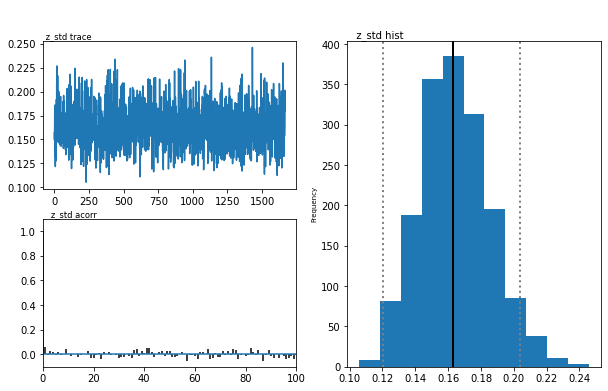

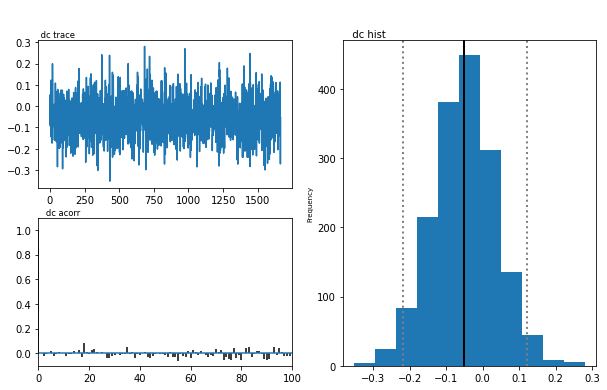

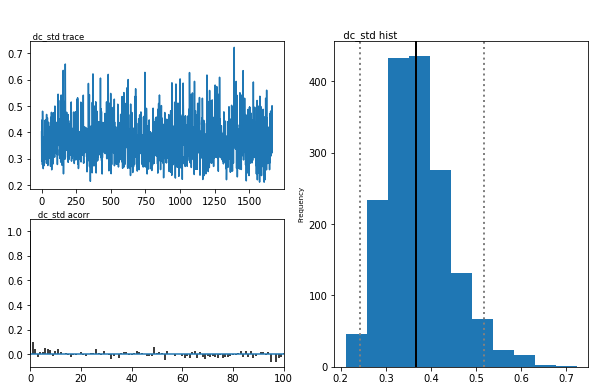

In [119]:
#Visually check the model
m.plot_posteriors()

In [120]:
"""
If all goes well in previous step then...
"""
#save combined model
m.save(os.path.join(mypath, full_model_name, 'modelfit-combined.model'))  # save combined modelto disk
# SAVE POINT ESTIMATES
print("saving stats...")
results = m.gen_stats()  # point estimate for each parameter and subject
results.to_csv(os.path.join(mypath, full_model_name, 'results-combined.csv'))
# save the DIC for this model
text_file = open(os.path.join(mypath, full_model_name, 'DIC-combined.txt'), 'w')
text_file.write("Combined model: {}\n".format(m.dic))
text_file.close()
print('done')
# SAVE TRACES
print("saving traces...")
# get the names for all nodes that are available here
group_traces = m.get_group_traces()
group_traces.to_csv(os.path.join(mypath, full_model_name, 'group_traces.csv'))
all_traces = m.get_traces()
all_traces.to_csv(os.path.join(mypath, full_model_name, 'all_traces.csv'))
print('done')
# CONCATENATE MODEL COMPARISON
# average model comparison values across chains
print('concatenating model comparison...')
fls = glob.glob(os.path.join(mypath, full_model_name, 'model_comparison_md*.csv'))
tmpdf = pd.concat([pd.read_csv(f) for f in fls ])
# average over chains
df2 = tmpdf.describe().loc[['mean']]
df2.to_csv(os.path.join(mypath, full_model_name, 'model_comparison.csv')) # save comparison to disk
print('done')

saving stats...
done
saving traces...
done
concatenating model comparison...
done


# POSTERIOR PREDICTIVES TO ASSESS MODEL FIT

In [122]:
starttime = time.time()
print("computing ppc")
# specify how many samples are needed
m = hddm.load(os.path.join(mypath,full_model_name, 'modelfit-combined.model'))
nsmp = 500
ppc = hddm.utils.post_pred_gen(m, append_data=True, samples=nsmp)
# save as pandas dataframe
ppc.to_csv(os.path.join(mypath, full_model_name, 'ppc_data.csv'), index=True)
elapsed = time.time() - starttime
print( "\nElapsed time for %s, PPC: %f seconds\n" %(full_model_name,elapsed))

computing ppc
 [------------------107%------------------] 43 of 40 complete in 4192.7 sec
Elapsed time for stimcoding_nohist, PPC: 4248.837746 seconds



In [123]:
ppc_compare = hddm.utils.post_pred_stats(mydata, ppc)

In [124]:
ppc_compare

,observed,mean,std,SEM,MSE,credible,quantile,mahalanobis
stat,,,,,,,,
accuracy,0.490941,0.492048,0.306252,0.000001,0.093795,True,45.0,0.003613
mean_ub,0.791704,0.815397,0.188656,0.000561,0.036152,True,50.0,0.125589
std_ub,0.299863,0.236601,0.095085,0.004002,0.013042,True,80.0,0.665326
10q_ub,0.467477,0.567953,0.147048,0.010096,0.031735,True,17.5,0.683290
30q_ub,0.607337,0.683959,0.170220,0.005871,0.034853,True,35.0,0.450134
50q_ub,0.734843,0.776483,0.188123,0.001734,0.037119,True,50.0,0.221343
70q_ub,0.903195,0.898970,0.227970,0.000018,0.051992,True,52.5,0.018533
90q_ub,1.181416,1.096264,0.274596,0.007251,0.082652,True,62.5,0.310102
mean_lb,-0.762101,-0.798749,0.196035,0.001343,0.039770,True,60.0,0.186947


In [125]:
ppc_compare.to_csv(os.path.join(mypath, full_model_name, 'ppc_compare.csv'), index=False,header=True)

code in cell below is for debugging purposes only

In [ ]:
"""
import pymc as pm
import numpy as np
import pymc.progressbar as pbar

def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            sampled_data.reset_index(inplace=True)  # Only modification of original Kabuki code
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets

def pst_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.iloc[obs['node'].value.index]) for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)


    for name, data in iter_data:
        print(name)
        print(data['subj_idx'])
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])

testm = hddm.load(os.path.join(mypath,full_model_name, 'modelfit-md2.model'))
ppc = pst_pred_gen(testm, append_data=True, samples=nsmp)
"""

# QUANTILE OPTIMISATION

In [126]:
# http://ski.clps.brown.edu/hddm_docs/howto.html#run-quantile-opimization
subj_params = []
bic_temp = []

for subj_idx, subj_data in mydata.groupby('subj_idx'):
    m_subj = make_model(subj_data, model, 1,lag)
    thismodel = m_subj.optimize('gsquare', quantiles=[0.1, 0.3, 0.5, 0.7, 0.9], n_runs=5)
    thismodel.update({'subj_idx':subj_idx}) # keep original subject number
    subj_params.append(thismodel)
    bic_temp.append(m_subj.bic_info)

params = pd.DataFrame(subj_params)
params.to_csv(os.path.join(mypath, full_model_name, 'Gsquare.csv'))
pd.DataFrame(bic_temp).to_csv(os.path.join(mypath, full_model_name, 'BIC.csv'))
print("QUANTILE OPTIMISATION. DONE!!!")

'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 1873.810783
         Iterations: 14
         Function evaluations: 1259
Optimization terminated successfully.
         Current function value: 1937.119078
         Iterations: 9
         Function evaluations: 833
Optimization terminated successfully.
         Current function value: 1873.733333
         Iterations: 18
         Function evaluations: 1756
Optimization terminated successfully.
         Current function value: 1884.636795
         Iterations: 12
         Function evaluations: 1047
Optimization terminated successfully.
         Current function value: 1873.741205
         Iterations: 11
         Function evaluations: 976
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 1934.969549
         Iterations: 12
         Function evaluations: 1109
Optimization terminated successfully.
         Current function value: 1936.055586
         Iterations: 13
         Function evaluations: 1163
Optimization terminated successfully.
         Current function value: 1949.045033
         Iterations: 16
         Function evaluations: 2160
Optimization terminated successfully.
         Current function value: 1935.004682
         Iterations: 10
         Function evaluations: 894
Optimization terminated successfully.
         Current function value: 1934.975340
         Iterations: 11
         Function evaluations: 970
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: -28606.793805
         Iterations: 15
         Function evaluations: 2832
Optimization terminated successfully.
         Current function value: 2420.764696
         Iterations: 13
         Function evaluations: 1227


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: -3182.281912
         Iterations: 17
         Function evaluations: 2884


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:2644: RuntimeWarning: invalid value encountered in subtract
  if (fx2 - fval) > delta:


Optimization terminated successfully.
         Current function value: inf
         Iterations: 8
         Function evaluations: 1220
Optimization terminated successfully.
         Current function value: 2428.377057
         Iterations: 8
         Function evaluations: 859
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2253.190998
         Iterations: 15
         Function evaluations: 1380
Optimization terminated successfully.
         Current function value: 2253.117915
         Iterations: 15
         Function evaluations: 1374
Optimization terminated successfully.
         Current function value: 2254.328776
         Iterations: 6
         Function evaluations: 527
Optimization terminated successfully.
         Current function value: 2259.495066
         Iterations: 10
         Function evaluations: 919
Optimization terminated successfully.
         Current function value: 2255.705045
         Iterations: 5
         Function evaluations: 447
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2422.397954
         Iterations: 8
         Function evaluations: 849
Optimization terminated successfully.
         Current function value: 2423.888342
         Iterations: 7
         Function evaluations: 695
Optimization terminated successfully.
         Current function value: 2422.316646
         Iterations: 9
         Function evaluations: 970
Optimization terminated successfully.
         Current function value: 2422.451622
         Iterations: 8
         Function evaluations: 820
Optimization terminated successfully.
         Current function value: 2423.898280
         Iterations: 9
         Function evaluations: 882
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2150.369438
         Iterations: 10
         Function evaluations: 1017
Optimization terminated successfully.
         Current function value: 2132.126067
         Iterations: 7
         Function evaluations: 613
Optimization terminated successfully.
         Current function value: 2128.842673
         Iterations: 10
         Function evaluations: 913
Optimization terminated successfully.
         Current function value: 2128.218186
         Iterations: 11
         Function evaluations: 1008


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2128.961483
         Iterations: 17
         Function evaluations: 1648
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2299.021107
         Iterations: 8
         Function evaluations: 709
Optimization terminated successfully.
         Current function value: 2298.783741
         Iterations: 8
         Function evaluations: 711
Optimization terminated successfully.
         Current function value: 2293.907842
         Iterations: 6
         Function evaluations: 547
Optimization terminated successfully.
         Current function value: 2298.696739
         Iterations: 8
         Function evaluations: 715
Optimization terminated successfully.
         Current function value: 2298.373609
         Iterations: 8
         Function evaluations: 749
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2269.783890
         Iterations: 11
         Function evaluations: 1030
Optimization terminated successfully.
         Current function value: 2271.726468
         Iterations: 11
         Function evaluations: 982
Optimization terminated successfully.
         Current function value: 2323.459527
         Iterations: 12
         Function evaluations: 1103
Optimization terminated successfully.
         Current function value: 2270.511883
         Iterations: 7
         Function evaluations: 612
Optimization terminated successfully.
         Current function value: 2269.792871
         Iterations: 9
         Function evaluations: 816
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 1662.584897
         Iterations: 13
         Function evaluations: 1284
Optimization terminated successfully.
         Current function value: 1662.559800
         Iterations: 14
         Function evaluations: 1376
Optimization terminated successfully.
         Current function value: 1662.694245
         Iterations: 10
         Function evaluations: 944
Optimization terminated successfully.
         Current function value: 1662.619246
         Iterations: 12
         Function evaluations: 1137
Optimization terminated successfully.
         Current function value: 1662.558709
         Iterations: 13
         Function evaluations: 1271
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 1842.125605
         Iterations: 7
         Function evaluations: 706
Optimization terminated successfully.
         Current function value: 1842.086683
         Iterations: 7
         Function evaluations: 668
Optimization terminated successfully.
         Current function value: 1883.122358
         Iterations: 7
         Function evaluations: 688
Optimization terminated successfully.
         Current function value: 1842.167306
         Iterations: 7
         Function evaluations: 652
Optimization terminated successfully.
         Current function value: 1883.118452
         Iterations: 4
         Function evaluations: 430
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2037.253820
         Iterations: 9
         Function evaluations: 866
Optimization terminated successfully.
         Current function value: 2037.235624
         Iterations: 6
         Function evaluations: 607
Optimization terminated successfully.
         Current function value: 2037.927687
         Iterations: 9
         Function evaluations: 922
Optimization terminated successfully.
         Current function value: 2037.264710
         Iterations: 7
         Function evaluations: 677
Optimization terminated successfully.
         Current function value: 7171.320723
         Iterations: 1
         Function evaluations: 89
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2384.369816
         Iterations: 17
         Function evaluations: 1689
Optimization terminated successfully.
         Current function value: 2383.828563
         Iterations: 14
         Function evaluations: 1272


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1987: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


Optimization terminated successfully.
         Current function value: 2384.067489
         Iterations: 14
         Function evaluations: 1198
Optimization terminated successfully.
         Current function value: 2384.433659
         Iterations: 14
         Function evaluations: 1316
Optimization terminated successfully.
         Current function value: 2384.216474
         Iterations: 17
         Function evaluations: 1619
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2160.208857
         Iterations: 10
         Function evaluations: 879
Optimization terminated successfully.
         Current function value: 2159.460381
         Iterations: 8
         Function evaluations: 715
Optimization terminated successfully.
         Current function value: 2159.938082
         Iterations: 8
         Function evaluations: 694
Optimization terminated successfully.
         Current function value: 2163.334850
         Iterations: 8
         Function evaluations: 790
Optimization terminated successfully.
         Current function value: 2159.827973
         Iterations: 8
         Function evaluations: 726
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2280.163950
         Iterations: 11
         Function evaluations: 989
Optimization terminated successfully.
         Current function value: 2280.740449
         Iterations: 8
         Function evaluations: 760
Optimization terminated successfully.
         Current function value: 2281.415212
         Iterations: 8
         Function evaluations: 756
Optimization terminated successfully.
         Current function value: 2280.720712
         Iterations: 8
         Function evaluations: 750
Optimization terminated successfully.
         Current function value: 2282.881100
         Iterations: 8
         Function evaluations: 735
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2058.693219
         Iterations: 10
         Function evaluations: 925
Optimization terminated successfully.
         Current function value: 2058.642596
         Iterations: 8
         Function evaluations: 691
Optimization terminated successfully.
         Current function value: 2059.291189
         Iterations: 8
         Function evaluations: 702
Optimization terminated successfully.
         Current function value: 2058.633428
         Iterations: 10
         Function evaluations: 917
Optimization terminated successfully.
         Current function value: 2059.156531
         Iterations: 8
         Function evaluations: 737
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2360.650044
         Iterations: 10
         Function evaluations: 1338
Optimization terminated successfully.
         Current function value: 2305.673018
         Iterations: 8
         Function evaluations: 691
Optimization terminated successfully.
         Current function value: 2305.637697
         Iterations: 8
         Function evaluations: 742


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2305.656083
         Iterations: 8
         Function evaluations: 672
Optimization terminated successfully.
         Current function value: 2306.081429
         Iterations: 9
         Function evaluations: 768
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2526.922191
         Iterations: 6
         Function evaluations: 628
Optimization terminated successfully.
         Current function value: 2516.187385
         Iterations: 11
         Function evaluations: 1013
Optimization terminated successfully.
         Current function value: 2513.116784
         Iterations: 4
         Function evaluations: 356
Optimization terminated successfully.
         Current function value: 2515.659088
         Iterations: 10
         Function evaluations: 904
Optimization terminated successfully.
         Current function value: 2521.182342
         Iterations: 9
         Function evaluations: 808
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2188.224103
         Iterations: 8
         Function evaluations: 703
Optimization terminated successfully.
         Current function value: 2184.787081
         Iterations: 11
         Function evaluations: 1005
Optimization terminated successfully.
         Current function value: 2188.185767
         Iterations: 8
         Function evaluations: 697
Optimization terminated successfully.
         Current function value: 2187.424261
         Iterations: 8
         Function evaluations: 703
Optimization terminated successfully.
         Current function value: 2184.691426
         Iterations: 12
         Function evaluations: 1076
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2331.532216
         Iterations: 9
         Function evaluations: 1136
Optimization terminated successfully.
         Current function value: 2329.941491
         Iterations: 10
         Function evaluations: 1249
Optimization terminated successfully.
         Current function value: 2327.064127
         Iterations: 15
         Function evaluations: 2067


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2329.336787
         Iterations: 10
         Function evaluations: 1261
Optimization terminated successfully.
         Current function value: 2327.846837
         Iterations: 13
         Function evaluations: 2082
'nlag' specified but model is without history effect. 'nlag' value is ignored



/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 2577.765973
         Iterations: 8
         Function evaluations: 727


/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1986: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 2500.216225
         Iterations: 10
         Function evaluations: 838
Optimization terminated successfully.
         Current function value: 2577.543145
         Iterations: 8
         Function evaluations: 746
Optimization terminated successfully.
         Current function value: 2578.047894
         Iterations: 8
         Function evaluations: 753
Optimization terminated successfully.
         Current function value: 2579.682546
         Iterations: 9
         Function evaluations: 833
QUANTILE OPTIMISATION. DONE!!!


In [95]:
del bic